### 本baseline采用pytorch框架，应用ModelArts的Notebook进行开发

### 数据集获取
将您OBS桶中的数据文件加载到此notebook中，将如下代码中"obs-aifood-baseline"修改成您OBS桶名称。

In [14]:
#避免数据混乱，删掉重新导入
import os
import shutil
import moxing as mox
if os.path.exists('aifood')==True:
    shutil.rmtree('aifood')
if os.path.exists('work')==True:
    shutil.rmtree('work')

# OBS已设置公共可读

#efficientnet预训练模型
mox.file.copy_parallel('s3://c4ai/premodel/efficientnet-b7-dcc49843.pth','eff.pth')
# 大赛数据集
mox.file.copy_parallel('s3://obs-aifood-bj4/aifood','./aifood/')
# 添加的外部数据
mox.file.copy_parallel('s3://c4ai/data/post_data_2.zip','post_data.zip')
# ranger 优化器安装文件
mox.file.copy_parallel('s3://c4ai/data/ranger.zip','ranger.zip')

print("done")

INFO:root:Listing OBS: 1000
INFO:root:Listing OBS: 2000
INFO:root:Listing OBS: 3000
INFO:root:Listing OBS: 4000
INFO:root:Listing OBS: 5000
INFO:root:pid: None.	1000/5001
INFO:root:pid: None.	2000/5001
INFO:root:pid: None.	3000/5001
INFO:root:pid: None.	4000/5001
INFO:root:pid: None.	5000/5001


done


In [15]:
!unzip post_data.zip > /dev/null
!unzip ranger.zip > /dev/null
print('done')

replace Ranger-Deep-Learning-Optimizer/ranger/ranger.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
done


In [16]:
import os
import shutil
data_dir = 'work/'
to_dir = 'aifood/images/'
dir_name = os.listdir(data_dir)
# print(dir_name)
for i in dir_name:
    img_name = os.listdir(data_dir+i)
    mov_num = 0
    for j in img_name:
        if i=='冰激凌' or i=='玉米饼':#err 2
            if mov_num>250:
                print(i,'add',mov_num)
                break
        elif i=='土豆泥' or i=='甜甜圈':#err 3 , 4
            if mov_num>290:
#                 print('tudou')
                print(i,'add',mov_num)
                break
        elif i=='松鼠鱼' or i=='烤冷面' or i=='鸡蛋布丁':#err 1
            if mov_num>240:
                print(i,'add',mov_num)
                break
        else:
            if mov_num>230:
                print(i,'add',mov_num)
                break
        img_filename = data_dir+i+'/'+j
        to_filename = to_dir+i+'/'+j
#         print(img_filename,to_filename)
        shutil.move(img_filename,to_filename)
        mov_num+=1
#     print(len(img_name))

三明治 add 231
土豆泥 add 291
小米粥 add 231
松鼠鱼 add 241
烤冷面 add 241
玉米饼 add 251
甜甜圈 add 291
芒果班戟 add 231
鸡蛋布丁 add 241
冰激凌 add 251


In [4]:
#安装ranger优化器，
# refer https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer
# !git clone https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer
!pip install --upgrade pip
%cd Ranger-Deep-Learning-Optimizer
!pip install -e . 
%cd ..


    100% |████████████████████████████████| 1.5MB 120.2MB/s ta 0:00:01
  Found existing installation: pip 9.0.1
    Uninstalling pip-9.0.1:
      Successfully uninstalled pip-9.0.1
/home/ma-user/work/Ranger-Deep-Learning-Optimizer
Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
Obtaining file:///home/ma-user/work/Ranger-Deep-Learning-Optimizer
  Attempting uninstall: ranger
    Found existing installation: ranger 0.1.dev0
    Can't uninstall 'ranger'. No files were found to uninstall.
  Running setup.py develop for ranger
/home/ma-user/work


In [5]:
# !pip install ttach

In [5]:
# 安装efficientnet
# refer https://github.com/lukemelas/EfficientNet-PyTorch
!pip install efficientnet-pytorch

Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=17438 sha256=4b9c2b0dd47bf3b20fb20c9e5ecf0e56e75cc125bcbef3af9e2714a03ca997da
  Stored in directory: /home/ma-user/.cache/pip/wheels/de/6f/c3/c3512844ba6ea54cbdeeafec0b545a2e937bd3464d2bfcf522
Successfully built efficientnet-pytorch


### 加载依赖

In [6]:
%cd Ranger-Deep-Learning-Optimizer
from ranger import Ranger  # this is from ranger.py
from ranger import RangerVA  # this is from ranger913A.py
from ranger import RangerQH  # this is from rangerqh.py
%cd ..
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import random
import numpy as np
from efficientnet_pytorch import EfficientNet
# import ttach as tta

/home/ma-user/work/Ranger-Deep-Learning-Optimizer
/home/ma-user/work


### 加载数据集，并将其分为训练集和测试集

In [7]:
# 划分训练集和验证集
from torchvision.datasets import ImageFolder
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
size = 224
# 使用image net的mean std   简单的数据增强
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
train_transformer_ImageNet = transforms.Compose([
    transforms.Resize((size,size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.ToTensor(),
    normalize
])
 
val_transformer_ImageNet = transforms.Compose([
    transforms.Resize((size,size)),
    transforms.ToTensor(),
    normalize
])
# 目录文件
data_dir = 'aifood/images'
# 为了划分数据集，和自定义transform 所以参考如下链接写了一个这个
# refer https://blog.csdn.net/ncc1995/article/details/91125964
class MyDataset(Dataset):
    def __init__(self, filenames, labels, transform):
        self.filenames = filenames
        self.labels = labels
        self.transform = transform
 
    def __len__(self):
        return len(self.filenames)
 
    def __getitem__(self, idx):
        image = Image.open(self.filenames[idx]).convert('RGB')
        image = self.transform(image)
        return image, self.labels[idx]
    
def split_Train_Val_Data(data_dir, ratio, bs=16):
    global train_len
    global val_len
    """ the sum of ratio must equal to 1"""
    dataset = ImageFolder(data_dir)     # data_dir精确到分类目录的上一级
    character = [[] for i in range(len(dataset.classes))]
    print(dataset.class_to_idx)
    for x, y in dataset.samples:  # 将数据按类标存放
        character[y].append(x)
#     print(dataset.samples)
    train_inputs, val_inputs, test_inputs = [], [], []
    train_labels, val_labels, test_labels = [], [], []
    for i, data in enumerate(character):   # data为一类图片
        num_sample_train = int(len(data) * ratio[0])
        #print(num_sample_train)
        num_sample_val = int(len(data) * ratio[1])
        num_val_index = num_sample_train + num_sample_val
        # 这里打乱一下数据，实验表明，不打乱也没事
        random.seed(7)
        random.shuffle(data)
        
        for x in data[:num_sample_train]:
            train_inputs.append(str(x))
            train_labels.append(i)
        for x in data[num_sample_train:num_val_index]:
            val_inputs.append(str(x))
            val_labels.append(i)
    
    train_len = len(train_inputs)
    val_len = len(val_inputs)
    print("train_length:%d,val length:%d" %(train_len,val_len))
    
    train_dst = MyDataset(train_inputs, train_labels, train_transformer_ImageNet)
    valid_dst = MyDataset(val_inputs, val_labels, val_transformer_ImageNet)
    train_dataloader = DataLoader(train_dst,
                                  batch_size=bs, shuffle=True)
    val_dataloader = DataLoader(valid_dst,
                                  batch_size=bs, shuffle=False)
 
    return train_dataloader, val_dataloader
# 定义pytorch的dataloader，数据划分0.9 
data_loader = split_Train_Val_Data(data_dir,(0.9,0.1))

{'三明治': 0, '冰激凌': 1, '土豆泥': 2, '小米粥': 3, '松鼠鱼': 4, '烤冷面': 5, '玉米饼': 6, '甜甜圈': 7, '芒果班戟': 8, '鸡蛋布丁': 9}
train_length:6741,val length:749


In [8]:
# 为了保证后面和官方的baseline一致，
dataloders = {x:  data_loader[i] for i,x in enumerate(['train', 'val']) }
dataset_sizes = {'train':train_len, 'val':val_len}
print(dataset_sizes)
# use gpu or not
use_gpu = torch.cuda.is_available()

{'train': 6741, 'val': 749}


### 训练网络

In [9]:
def train_model(model, lossfunc, optimizer, scheduler, num_epochs=10):
    start_time = time.time()
    elapsed_time = 0
    
    best_model_wts = model.state_dict()
    best_acc = 0.0
    train_acc = []
    valid_acc = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
#         for phase in ['val']:

            if phase == 'train':
#                 
                model.train(True)  # Set model to training mode
            else:
                
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0.0

            # Iterate over data.
            for data in dataloders[phase]:
                # get the inputs
                inputs, labels = data
                

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = lossfunc(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data
                running_corrects += torch.sum(preds == labels.data).to(torch.float32)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if phase == 'val':
                valid_acc.append(epoch_acc)
            else:
                train_acc.append(epoch_acc)
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
        epch_model_name ='checkpiont/ep{}_train{}_val{}.pth'.format(epoch,train_acc[-1],valid_acc[-1],)

        torch.save(model.state_dict(), epch_model_name)
        print('model saved : ',epch_model_name)
        elapsed_time = time.time() - start_time - elapsed_time
        print('epoch complete in {:.0f}m {:.0f}s'.format(
            elapsed_time // 60, elapsed_time % 60))

        

        # 这里使用了学习率调整策略
        scheduler.step(valid_acc[-1])
    elapsed_time = time.time() - start_time
    print('Training complete in {:.0f}m {:.0f}s'.format(
        elapsed_time // 60, elapsed_time % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
  
    return model,train_acc,valid_acc
if os.path.exists('checkpiont')==False:
    os.mkdir('checkpiont')


In [11]:
 # 标签平滑
import torch.nn as nn
import torch.nn.functional as F
import torch

# export label smoothing
from torch.autograd import Variable
def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction == 'mean' else loss.sum() if reduction == 'sum' else loss
def lin_comb(a, b, epsilon):
    return epsilon * a + b * (1 - epsilon)
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, epsilon: float = 0.1, reduction='mean'):
        super().__init__()
        self.epsilon, self.reduction = epsilon, reduction

    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        loss = reduce_loss(-log_preds.sum(dim=-1), self.reduction)
        nll = F.nll_loss(log_preds, target, reduction=self.reduction)
        return lin_comb(loss / c, nll, self.epsilon)

### 模型训练
采用resnet50神经网络结构训练模型,模型训练需要一定时间，等待该段代码运行完成后再往下执行。

In [17]:
# 冻结网络参数，训练最后一层

# 删掉checkpiont文件
%cd checkpiont 
!rm * 
%cd ..

# 使用EfficientNet-b7模型
model_ft = EfficientNet.from_name('efficientnet-b7') 

# 训练权重我自己下载的，然后拷贝到了notebook目录下面
# 下载链接:https://github.com/lukemelas/EfficientNet-PyTorch/releases
model_ft.load_state_dict(torch.load('eff.pth'))
num_ftrs = model_ft._fc.in_features

# 加入dropout，赋值过拟合
model_ft._fc = nn.Sequential(nn.Dropout(0.4),nn.Linear(num_ftrs, 10))

# model_ft.load_state_dict(torch.load('eff_81.pth'))


if use_gpu:
    model_ft = model_ft.cuda()

# define loss function
lossfunc = nn.CrossEntropyLoss()
# lossfunc = LabelSmoothingCrossEntropy()

# 冻结参数，只训练最后一层,训练10个epoch后解冻，训练全部参数
parameters = list(model_ft._fc.parameters())
# optimizer_ft = optim.SGD(parameters, lr=0.001, momentum=0.9, nesterov=True)

# 使用Ranger优化器
optimizer_ft = Ranger(parameters, 0.001,weight_decay=0)

# 使用ReduceLROnPlateau学习调度器，如果2个epoch准确率没有提升，则减少学习率
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft,mode='max',patience=2,verbose=True)
model_ft,train_acc,valid_acc = train_model(model=model_ft,
                           lossfunc=lossfunc,
                           optimizer=optimizer_ft,
                           scheduler=exp_lr_scheduler,
                           num_epochs=15)
torch.save(model_ft.state_dict(), './prefc.pth')
torch.cuda.empty_cache()


/home/ma-user/work/checkpiont
rm: cannot remove '*': No such file or directory
/home/ma-user/work
Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers
Epoch 0/0
----------
train Loss: 0.1328 Acc: 0.3189
val Loss: 0.1156 Acc: 0.6569
model saved :  checkpiont/ep0_train0.3189437985420227_val0.6568758487701416.pth
epoch complete in 2m 36s
Training complete in 2m 36s
Best val Acc: 0.656876


[]

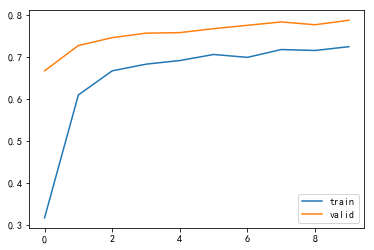

In [10]:
# 可视化
%matplotlib inline
import matplotlib.pylab as plt
plt.plot(train_acc,label="train")
plt.plot(valid_acc,label='valid')
plt.legend()
plt.plot()

In [18]:
torch.cuda.empty_cache()

